2025-08-19 13:29:30,301 P[2080] [MainThread 12376] Error with IEF: Invalid RIC
2025-08-19 13:29:30,303 P[2080] [MainThread 12376] IEF: Invalid RIC | 
C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

2025-08-19 13:29:33,818 P[2080] [MainThread 12376] Error with IGEB: Invalid RIC
2025-08-19 13:29:33,821 P[2080] [MainThread 12376] IGEB: Invalid RIC | 
C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



Selected identifiers:
  US_Equity    -> SPY
  UST_7_10Y    -> IEF.P
  IG_Credit    -> IGEB.P
  HY_Credit    -> HYG
  Oil          -> USO
  Gold         -> GLD


US_Equity  UST_7_10Y  IG_Credit  HY_Credit    Oil    Gold
Date                                                                 
2025-08-13     644.89      95.75     45.629      80.61  72.46  309.21
2025-08-14     644.95      95.42     45.515       80.4  73.74  307.25
2025-08-15     643.44      95.23      45.47      80.46   72.8  307.43
2025-08-18      643.3     95.135      45.42       80.4  73.17  306.95
2025-08-19    639.305      95.39     45.465     80.375  72.13  305.46

US_Equity  UST_7_10Y  IG_Credit  HY_Credit       Oil      Gold
Date                                                                      
2025-08-13   0.003417   0.003924   0.004151   0.002609  -0.00674  0.003045
2025-08-14   0.000093  -0.003452  -0.002502  -0.002609  0.017511 -0.006359
2025-08-15  -0.002344  -0.001993  -0.000989   0.000746 -0.012829  0.000586
2025-08-18  -0.000218  -0.000998    -0.0011  -0.000746   0.00507 -0.001563
2025-08-19   -0.00623   0.002677    0.00099  -0.000311 -0.014315 -0.004866

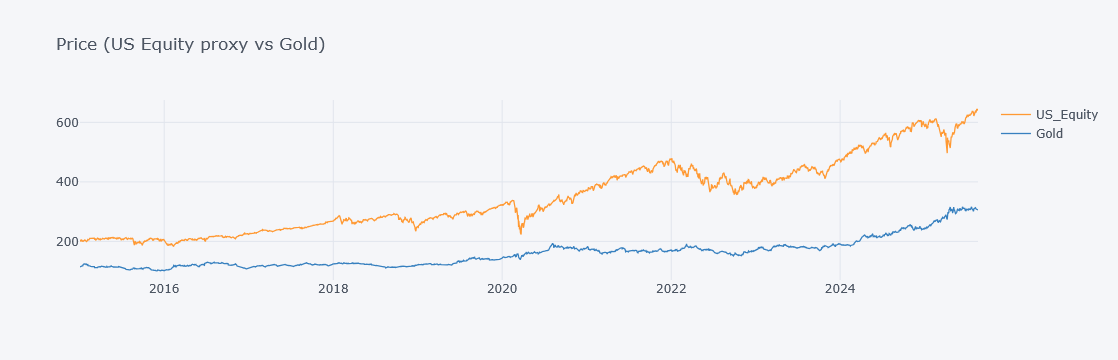

In [3]:
# === Auth from api_key.txt + Robust ETL (skip missing sleeves) ===
from pathlib import Path
from datetime import datetime
import os, numpy as np, pandas as pd
import eikon as ek
import cufflinks as cf

cf.go_offline()

# --- 1) Load App Key from local file ---
KEY_PATH = Path("api_key.txt")
if not KEY_PATH.exists():
    raise FileNotFoundError("api_key.txt not found next to this notebook.")
APP_KEY = KEY_PATH.read_text(encoding="utf-8").strip().strip('"').strip("'")
if not APP_KEY:
    raise RuntimeError("api_key.txt is empty. Put only the key on a single line.")

ek.set_app_key(APP_KEY)
# If you previously saw 'no proxy/port' errors, you can force it (find port in %APPDATA%\\Thomson Reuters\\Eikon API Proxy\\.portInUse):
# ek.set_port_number(9000)

# --- 2) Universe with broad fallbacks (and .P auto-try) ---
UNIVERSE = {
    "US_Equity":  {"candidates": ["SPY","IVV","VOO",".SPX"], "asset": "Equity"},
    # Bond sleeve: 7–10y → broad core → long → 3–7y → 10y yield
    "UST_7_10Y":  {"candidates": ["IEF","VGIT","SCHR","AGG","BND","TLT","IEI","US10YT=RR"], "asset": "Bond"},
    "IG_Credit":  {"candidates": ["LQD","IGEB","IGLB","BND"], "asset": "Credit"},
    "HY_Credit":  {"candidates": ["HYG","JNK","USHY"], "asset": "Credit"},
    # Oil: ETF proxies first (including energy equities) → futures last
    "Oil":        {"candidates": ["USO","DBO","BNO","XLE","XOP","CLc1","LCOc1"], "asset": "Commodity"},
    "Gold":       {"candidates": ["GLD","IAU","XAU="], "asset": "Commodity"},
}

START_DATE = "2015-01-01"
END_DATE   = datetime.today().strftime("%Y-%m-%d")

# --- 3) Helpers ---
def _normalize_price_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    if "CLOSE" not in df.columns:
        if "VALUE" in df.columns:
            df = df.rename(columns={"VALUE": "CLOSE"})
        else:
            num = [c for c in df.columns if df[c].dtype.kind in "fiu"]
            if len(num) == 1:
                df = df.rename(columns={num[0]: "CLOSE"})
            else:
                raise KeyError(f"No obvious price column in {df.columns.tolist()}")
    return df

def _probe_timeseries(ric: str, interval="daily") -> bool:
    try:
        probe = ek.get_timeseries(ric, count=5, interval=interval)
        return probe is not None and not probe.empty
    except Exception:
        return False

def _resolve_to_ric(symbol: str) -> str | None:
    # 1) Already works?
    if _probe_timeseries(symbol):
        return symbol
    # 2) Ask symbology (primary RIC / venue)
    try:
        df, err = ek.get_data(symbol, ["TR.PrimaryRIC","TR.RIC","TR.TradeVenueCode"], field_name=True)
        if err is None and df is not None and not df.empty:
            for col in ("TR.PrimaryRIC","TR.RIC"):
                if col in df.columns:
                    ric = str(df[col].dropna().astype(str).iloc[0])
                    if ric and ric != "None" and _probe_timeseries(ric):
                        return ric
            if "TR.TradeVenueCode" in df.columns:
                venue = str(df["TR.TradeVenueCode"].iloc[0]).upper()
                if "ARCA" in venue:
                    ric_p = f"{symbol}.P"
                    if _probe_timeseries(ric_p):
                        return ric_p
    except Exception:
        pass
    # 3) Blind-try .P for ETFs
    if symbol.isalpha():
        ric_p = f"{symbol}.P"
        if _probe_timeseries(ric_p):
            return ric_p
    return None

def fetch_first_entitled(candidates, start=START_DATE, end=END_DATE, interval="daily"):
    for s in candidates:
        ric = _resolve_to_ric(s) or s  # allow futures like CLc1 / cash like XAU=
        if _probe_timeseries(ric, interval=interval):
            ts = ek.get_timeseries(ric, start_date=start, end_date=end, interval=interval)
            if ts is not None and not ts.empty:
                ts = _normalize_price_cols(ts)
                return ric, ts[["CLOSE"]]
    raise RuntimeError(f"No entitled/valid instruments among: {candidates}")

def build_price_panel(universe: dict, start=START_DATE, end=END_DATE, interval="daily", skip_missing=True):
    cols, chosen, skipped = {}, {}, []
    for label, meta in universe.items():
        try:
            ric, df = fetch_first_entitled(meta["candidates"], start=start, end=end, interval=interval)
            cols[label] = df["CLOSE"].rename(label)
            chosen[label] = ric
        except Exception as e:
            if skip_missing:
                skipped.append((label, str(e)))
            else:
                raise
    if not cols:
        raise RuntimeError("No instruments could be downloaded. Check entitlements and network.")
    panel = pd.concat(cols.values(), axis=1).sort_index().ffill()
    return panel, chosen, skipped

def compute_log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(price_df / price_df.shift(1)).dropna(how="all")

# --- 4) Run ETL & preview ---
px, selected_ids, skipped = build_price_panel(UNIVERSE, START_DATE, END_DATE, interval="daily", skip_missing=True)
rets = compute_log_returns(px)

print("Selected identifiers:")
for k, v in selected_ids.items():
    print(f"  {k:12s} -> {v}")
if skipped:
    print("\nSkipped (no entitlement/valid RIC found):")
    for name, why in skipped:
        print(f"  {name:12s} : {why}")

display(px.tail())
display(rets.tail())

# Quiet cufflinks datetime deprecation by stringifying index for plotting
plot_df = px[[c for c in ["US_Equity","Gold"] if c in px.columns]].copy()
if not plot_df.empty:
    plot_df.index = plot_df.index.strftime("%Y-%m-%d")
    plot_df.iplot(title="Price (US Equity proxy vs Gold)")


Summary diagnostics: annualized return/vol, Sharpe, max drawdown, correlations.

Control portfolios:

Control A: Equal-weight across available sleeves.

Control B: Classic 60/40 (SPY / IEF.P).

Test portfolios:

Test 1: Momentum tilt (12–1 month cross-asset, top 3 equal-weight, monthly rebalance).

Test 2: Risk parity (1/vol weights on 63-day vol, long-only, monthly rebalance).

Assumptions: daily data, 252 trading days/yr, rf≈0, no fees/slippage (we’ll add later).

In [5]:
# Uses px (prices), rets (log returns), selected_ids from your ETL cell

import numpy as np
import pandas as pd

ANN = 252

def perf_table(r: pd.DataFrame) -> pd.DataFrame:
    r = r.dropna()
    if r.empty: 
        return pd.DataFrame()

    curve = (r + 1).cumprod()
    years = len(r) / ANN

    cagr = curve.iloc[-1]**(1/years) - 1
    vol  = r.std() * np.sqrt(ANN)
    sharpe = (r.mean() * ANN) / (r.std() * np.sqrt(ANN))
    # Max drawdown
    roll_max = curve.cummax()
    dd = (curve/roll_max - 1)
    mdd = dd.min()

    out = pd.DataFrame({
        "CAGR": cagr,
        "Ann.Vol": vol,
        "Sharpe": sharpe,
        "MaxDD": mdd
    }).sort_values("Sharpe", ascending=False)
    return out

# Summary (assets)
asset_stats = perf_table(rets)
display(asset_stats.style.format("{:.2%}"))

# Correlation (assets)
corr = rets.corr()
display(corr)

print("\nSelected identifiers:")
for k, v in selected_ids.items():
    print(f"  {k:12s} -> {v}")


US_Equity  UST_7_10Y  IG_Credit  HY_Credit       Oil      Gold
US_Equity   1.000000  -0.133574   0.296172   0.757978  0.316094  0.039118
UST_7_10Y  -0.133574   1.000000   0.711271   0.149301 -0.160132  0.345883
IG_Credit   0.296172   0.711271   1.000000   0.568747  0.036671  0.294826
HY_Credit   0.757978   0.149301   0.568747   1.000000  0.306385  0.130556
Oil         0.316094  -0.160132   0.036671   0.306385  1.000000  0.087775
Gold        0.039118   0.345883   0.294826   0.130556  0.087775  1.000000


Selected identifiers:
  US_Equity    -> SPY
  UST_7_10Y    -> IEF.P
  IG_Credit    -> IGEB.P
  HY_Credit    -> HYG
  Oil          -> USO
  Gold         -> GLD


In [6]:
import numpy as np
import pandas as pd

# Utility: month-end dates
month_ends = rets.resample("M").last().index

def momentum_weights(px: pd.DataFrame, top_n=3, lookback_days=252, skip_days=21) -> pd.DataFrame:
    # compute momentum on month-ends
    mom = (px.shift(skip_days) / px.shift(lookback_days+skip_days) - 1)
    mom_me = mom.reindex(month_ends).dropna(how="all")
    w = []
    for dt, row in mom_me.iterrows():
        top = row.dropna().sort_values(ascending=False).head(top_n).index
        ww = pd.Series(0.0, index=px.columns)
        if len(top) > 0:
            ww[top] = 1.0 / len(top)
        ww.name = dt
        w.append(ww)
    w = pd.DataFrame(w)
    # forward-fill daily
    return w.reindex(rets.index).ffill().fillna(0.0)

def risk_parity_weights(rets: pd.DataFrame, vol_lookback=63) -> pd.DataFrame:
    rolling_vol = rets.rolling(vol_lookback).std()
    vol_me = rolling_vol.reindex(month_ends).dropna(how="all")
    w = []
    for dt, row in vol_me.iterrows():
        inv = 1.0 / row.replace(0, np.nan)
        inv = inv.clip(lower=0).dropna()
        ww = pd.Series(0.0, index=rets.columns)
        if inv.sum() > 0:
            ww[inv.index] = inv / inv.sum()
        ww.name = dt
        w.append(ww)
    w = pd.DataFrame(w)
    return w.reindex(rets.index).ffill().fillna(0.0)

def equal_weight_weights(cols, k=None):
    cols = list(cols)
    if k is not None:
        cols = cols[:k]
    w = pd.Series(0.0, index=rets.columns)
    use = [c for c in cols if c in rets.columns]
    if use:
        w[use] = 1.0/len(use)
    return pd.DataFrame({month_ends[0]: w}).T.reindex(rets.index).ffill()

def sixty_forty_weights():
    w = pd.Series(0.0, index=rets.columns)
    if "US_Equity" in rets.columns and "UST_7_10Y" in rets.columns:
        w["US_Equity"] = 0.60
        w["UST_7_10Y"] = 0.40
    return pd.DataFrame({month_ends[0]: w}).T.reindex(rets.index).ffill()

def portfolio_returns(r: pd.DataFrame, w: pd.DataFrame) -> pd.Series:
    w = w.reindex(r.index).ffill().reindex(columns=r.columns).fillna(0.0)
    return (w * r).sum(axis=1)

# Build weights
w_eqw   = equal_weight_weights(rets.columns)             # Control A
w_6040  = sixty_forty_weights()                          # Control B
w_mom   = momentum_weights(px)                           # Test 1
w_rp    = risk_parity_weights(rets)                      # Test 2

# Portfolio returns
p_eqw   = portfolio_returns(rets, w_eqw)
p_6040  = portfolio_returns(rets, w_6040)
p_mom   = portfolio_returns(rets, w_mom)
p_rp    = portfolio_returns(rets, w_rp)

# Combine and score
port_rets = pd.DataFrame({
    "Control_EQW": p_eqw,
    "Control_60_40": p_6040,
    "Test_Momentum": p_mom,
    "Test_RiskParity": p_rp
}).dropna(how="all")

port_stats = perf_table(port_rets)
display(port_stats.style.format("{:.2%}"))

# Cumulative curves
curves = (port_rets + 1).cumprod()
curves.index = curves.index.strftime("%Y-%m-%d")  # friendlier for cufflinks
curves.iplot(title="Portfolio Curves — Control vs Tests")


C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2499475957.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [7]:
# --- Metrics helpers (Sharpe as a number, not %) ---
ANN = 252

def perf_table(r: pd.DataFrame) -> pd.DataFrame:
    r = r.dropna()
    if r.empty: 
        return pd.DataFrame()
    curve = (r + 1).cumprod()
    years = len(r) / ANN

    cagr   = curve.iloc[-1]**(1/years) - 1
    vol    = r.std() * np.sqrt(ANN)
    sharpe = (r.mean() / r.std()) * np.sqrt(ANN)   # numeric (no %)
    roll_max = curve.cummax()
    mdd = (curve/roll_max - 1).min()

    out = pd.DataFrame({"CAGR": cagr, "Ann.Vol": vol, "Sharpe": sharpe, "MaxDD": mdd})
    return out.sort_values("Sharpe", ascending=False)

# Convert your asset log-returns to simple returns for portfolio math
ret_simple = np.expm1(rets)   # simple ≈ exp(log) - 1

# --- Monthly rebalancing dates
month_ends = ret_simple.resample("M").last().index

# --- Control weight builders (monthly, then ffill)
def equal_weight_monthly(r: pd.DataFrame) -> pd.DataFrame:
    me = r.resample("M").last().index
    cols = [c for c in r.columns if r[c].notna().any()]
    w_me = pd.DataFrame(0.0, index=me, columns=r.columns)
    if cols:
        w_me[cols] = 1.0 / len(cols)
    return w_me.reindex(r.index).ffill()

def sixty_forty_monthly(r: pd.DataFrame) -> pd.DataFrame:
    me = r.resample("M").last().index
    w_me = pd.DataFrame(0.0, index=me, columns=r.columns)
    if "US_Equity" in r.columns and "UST_7_10Y" in r.columns:
        w_me.loc[:, "US_Equity"]  = 0.60
        w_me.loc[:, "UST_7_10Y"]  = 0.40
    return w_me.reindex(r.index).ffill()

# --- Test weight builders (you already have these; included here for completeness)
def momentum_weights(px: pd.DataFrame, top_n=3, lookback_days=252, skip_days=21) -> pd.DataFrame:
    mom = (px.shift(skip_days) / px.shift(lookback_days+skip_days) - 1)
    mom_me = mom.reindex(month_ends).dropna(how="all")
    w = []
    for dt, row in mom_me.iterrows():
        top = row.dropna().sort_values(ascending=False).head(top_n).index
        ww = pd.Series(0.0, index=px.columns)
        if len(top) > 0:
            ww[top] = 1.0 / len(top)
        ww.name = dt
        w.append(ww)
    w = pd.DataFrame(w)
    return w.reindex(ret_simple.index).ffill().fillna(0.0)

def risk_parity_weights(r: pd.DataFrame, vol_lookback=63) -> pd.DataFrame:
    rolling_vol = r.rolling(vol_lookback).std()
    vol_me = rolling_vol.reindex(month_ends).dropna(how="all")
    w = []
    for dt, row in vol_me.iterrows():
        inv = 1.0 / row.replace(0, np.nan)
        inv = inv.clip(lower=0).dropna()
        ww = pd.Series(0.0, index=r.columns)
        if inv.sum() > 0:
            ww[inv.index] = inv / inv.sum()
        ww.name = dt
        w.append(ww)
    w = pd.DataFrame(w)
    return w.reindex(ret_simple.index).ffill().fillna(0.0)

def portfolio_returns(r_simple: pd.DataFrame, w: pd.DataFrame) -> pd.Series:
    w = w.reindex(r_simple.index).ffill().reindex(columns=r_simple.columns).fillna(0.0)
    return (w * r_simple).sum(axis=1)

# --- Build weights
w_eqw   = equal_weight_monthly(ret_simple)      # Control A
w_6040  = sixty_forty_monthly(ret_simple)       # Control B
w_mom   = momentum_weights(px)                   # Test 1
w_rp    = risk_parity_weights(ret_simple)        # Test 2

# --- Compute portfolio returns
p_eqw   = portfolio_returns(ret_simple, w_eqw)
p_6040  = portfolio_returns(ret_simple, w_6040)
p_mom   = portfolio_returns(ret_simple, w_mom)
p_rp    = portfolio_returns(ret_simple, w_rp)

port_rets = pd.DataFrame({
    "Control_EQW": p_eqw,
    "Control_60_40": p_6040,
    "Test_Momentum": p_mom,
    "Test_RiskParity": p_rp
}).dropna(how="all")

# --- Score & plot
fmt = {"CAGR":"{:.2%}", "Ann.Vol":"{:.2%}", "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"}
display(perf_table(port_rets).style.format(fmt))

curves = (port_rets + 1).cumprod()
curves.index = curves.index.strftime("%Y-%m-%d")
curves.iplot(title="Portfolio Curves — Control vs Tests (Monthly Rebalance)")


C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2449686027.py:24: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2449686027.py:28: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2449686027.py:36: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [8]:
# Cap any sleeve's weight (e.g., Oil <= 5%)
ASSET_CAPS = {"Oil": 0.05}

def apply_caps(w: pd.DataFrame, caps: dict) -> pd.DataFrame:
    w = w.copy()
    for col, cap in caps.items():
        if col in w.columns:
            over = (w[col] > cap)
            if over.any():
                excess = (w[col] - cap).clip(lower=0)
                w.loc[over, col] = cap
                # redistribute excess pro-rata to other positive weights that are under cap
                others = [c for c in w.columns if c != col]
                base = w[others].clip(lower=0)
                denom = base.sum(axis=1).replace(0, np.nan)
                add = (base.T / denom).T.mul(excess, axis=0).fillna(0)
                w[others] = (w[others] + add).fillna(0)
    return w

# Rebuild weights (from previous cell’s functions)
w_eqw   = apply_caps(equal_weight_monthly(ret_simple), ASSET_CAPS)
w_6040  = apply_caps(sixty_forty_monthly(ret_simple), ASSET_CAPS)
w_mom   = apply_caps(momentum_weights(px), ASSET_CAPS)
w_rp    = apply_caps(risk_parity_weights(ret_simple), ASSET_CAPS)

p_eqw   = portfolio_returns(ret_simple, w_eqw)
p_6040  = portfolio_returns(ret_simple, w_6040)
p_mom   = portfolio_returns(ret_simple, w_mom)
p_rp    = portfolio_returns(ret_simple, w_rp)

port_rets_cap = pd.DataFrame({
    "Control_EQW_cap": p_eqw,
    "Control_60_40_cap": p_6040,
    "Test_Momentum_cap": p_mom,
    "Test_RiskParity_cap": p_rp
}).dropna(how="all")

fmt = {"CAGR":"{:.2%}", "Ann.Vol":"{:.2%}", "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"}
display(perf_table(port_rets_cap).style.format(fmt))

curves = (port_rets_cap + 1).cumprod()
curves.index = curves.index.strftime("%Y-%m-%d")
curves.iplot(title="Portfolios (Oil capped at 5%)")


C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2449686027.py:28: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\chris\AppData\Local\Temp\ipykernel_2080\2449686027.py:36: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



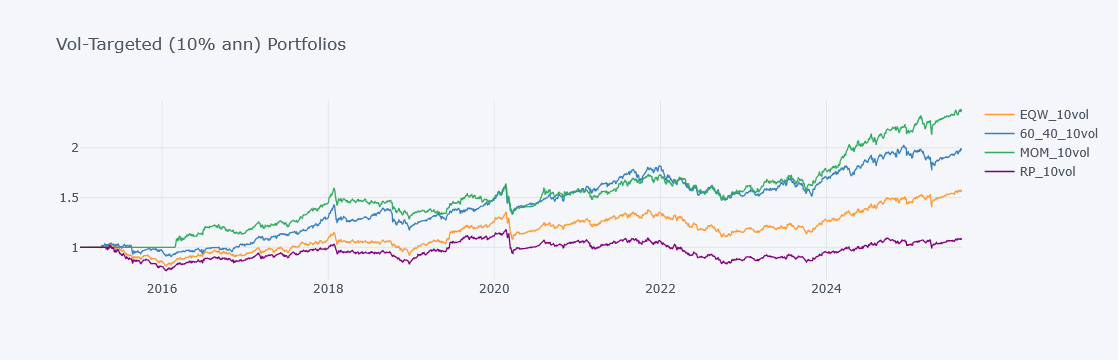

In [14]:
ANN = 252

def vol_target(r: pd.Series, target=0.10, lookback=63, lev_cap=3.0) -> pd.Series:
    # realized vol (annualized) over lookback
    rv = r.rolling(lookback).std() * np.sqrt(ANN)
    lev = (target / rv).clip(upper=lev_cap)
    return (r * lev.shift(1)).fillna(0.0)

vt = pd.DataFrame({
    "EQW_10vol": vol_target(port_rets_cap["Control_EQW_cap"]),
    "60_40_10vol": vol_target(port_rets_cap["Control_60_40_cap"]),
    "MOM_10vol": vol_target(port_rets_cap["Test_Momentum_cap"]),
    "RP_10vol": vol_target(port_rets_cap["Test_RiskParity_cap"]),
}).dropna()

display(perf_table(vt).style.format(fmt))

vt_curve = (vt + 1).cumprod()
vt_curve.index = vt_curve.index.strftime("%Y-%m-%d")
vt_curve.iplot(title="Vol-Targeted (10% ann) Portfolios")


In [16]:
# Assumes your auth block already ran and ek.set_app_key(APP_KEY) is set

import numpy as np, pandas as pd
from datetime import datetime
import eikon as ek

ANN = 252

# ---------- Timeseries helpers ----------
def _normalize_price_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    if "CLOSE" in df.columns: 
        return df
    if "VALUE" in df.columns:
        return df.rename(columns={"VALUE": "CLOSE"})
    num = [c for c in df.columns if df[c].dtype.kind in "fiu"]
    if len(num) == 1:
        return df.rename(columns={num[0]: "CLOSE"})
    raise KeyError(f"No obvious price column in {df.columns.tolist()}")

def get_px(ric: str, start="2015-01-01", end=None, interval="daily") -> pd.DataFrame:
    ts = ek.get_timeseries(ric, start_date=start, end_date=end, interval=interval)
    if ts is None or ts.empty:
        raise ValueError(f"No data for {ric}")
    return _normalize_price_cols(ts)[["CLOSE"]].rename(columns={"CLOSE": ric})

def get_many_px(rics, start="2015-01-01", end=None, interval="daily") -> pd.DataFrame:
    frames = []
    for r in rics:
        try:
            frames.append(get_px(r, start, end, interval))
        except Exception as e:
            print(f"[skip] {r}: {e}")
    if not frames: 
        raise RuntimeError("No price series pulled.")
    out = pd.concat(frames, axis=1).sort_index().ffill()
    return out

def logret(px: pd.DataFrame) -> pd.DataFrame:
    return np.log(px/px.shift(1)).dropna(how="all")

def simpret_from_log(rlog: pd.DataFrame) -> pd.DataFrame:
    return np.expm1(rlog)

# ---------- Fundamental fields (best-effort with fallbacks) ----------
FIELD_CANDIDATES = {
    "PE": ["TR.PriceEarningsRatio","TR.PE","TR.PEExcludeExtraordinary"],
    "DE": ["TR.TotalDebtToEquity","TR.DebtToEquity","TR.TotalDebttoEquity"],
    "EPS": ["TR.EPS","TR.EPSMean","TR.F.LastEPS","TR.EPSNormalized"],
    "BETA": ["TR.Beta","TR.Beta1Yr","TR.RawBeta","TR.AdjBeta","TR.CompanyBeta"],
    "MKT_CAP": ["TR.CompanyMarketCap"],
}

def get_best_fields(instruments, wanted=("PE","DE","EPS","BETA","MKT_CAP")) -> pd.DataFrame:
    fields = []
    for key in wanted:
        fields += FIELD_CANDIDATES.get(key, [])
    # Try all; keep the columns that actually come back
    df, err = ek.get_data(instruments, fields, field_name=True)
    if df is None: df = pd.DataFrame(index=instruments)
    # Keep only columns that exist
    keep_cols = [c for c in df.columns if c.startswith("TR.")]
    return df[keep_cols]

# ---------- Rolling beta (if TR beta not available) ----------
def rolling_beta(ret_asset: pd.Series, ret_bench: pd.Series, win=252) -> pd.Series:
    cov = ret_asset.rolling(win).cov(ret_bench)
    var = ret_bench.rolling(win).var()
    return (cov/var).rename("beta")

# ---------- Performance table ----------
def perf_table(r: pd.DataFrame) -> pd.DataFrame:
    r = r.dropna()
    curve = (1+r).cumprod()
    yrs = len(r)/ANN
    cagr = curve.iloc[-1]**(1/yrs) - 1
    vol  = r.std()*np.sqrt(ANN)
    sharpe = (r.mean()/r.std())*np.sqrt(ANN)
    mdd = (curve/curve.cummax()-1).min()
    out = pd.DataFrame({"CAGR":cagr, "Ann.Vol":vol, "Sharpe":sharpe, "MaxDD":mdd})
    return out.sort_values("Sharpe", ascending=False).applymap(lambda x: x if isinstance(x,float) else x)


In [18]:
# --- Your transaction ledger (one row per purchase) ---
# Columns: ric, buy_date (YYYY-MM-DD), qty, (optional) buy_price to override close
ledger = pd.DataFrame([
    {"ric":"SPY",    "buy_date":"2023-01-03", "qty":  50},
    {"ric":"GLD",    "buy_date":"2023-03-15", "qty":  25},
    {"ric":"LQD",    "buy_date":"2023-06-01", "qty":  40},
    {"ric":"AAPL.O", "buy_date":"2024-02-01", "qty":  20},
    # add more rows...
])

BENCH_RIC = "SPY"  # primary benchmark (market)
# optional 60/40 benchmark
BOND_PROXY = "IEI"  # or IEF / VGIT / SCHR; pick one you’re entitled to


In [34]:
# ---------- Robust symbol -> working RIC resolver ----------
def _probe_id(instr: str, count=5, interval="daily") -> bool:
    try:
        ts = ek.get_timeseries(instr, count=count, interval=interval)
        return ts is not None and not ts.empty
    except Exception:
        return False

_ALIAS = {
    # Commodities (gold)
    "GLD": ["GLD", "GLD.P", "IAU", "IAU.P", "XAU="],
    # Bond sleeves
    "IEI": ["IEI", "IEI.P", "VGIT", "VGIT.P", "SCHR", "IEF", "IEF.P", "AGG", "BND", "TLT", "US10YT=RR"],
    "IEF": ["IEF", "IEF.P", "VGIT", "VGIT.P", "SCHR", "AGG", "BND", "TLT", "US10YT=RR"],
    "VGIT": ["VGIT", "VGIT.P", "IEI", "IEI.P", "SCHR", "IEF", "IEF.P", "AGG", "BND", "TLT", "US10YT=RR"],
    # Common ETFs often on NYSE Arca (.P)
    "SPY": ["SPY", "SPY.P"],
    "LQD": ["LQD", "LQD.P"],
    "HYG": ["HYG", "HYG.P"],
    # Add others you use frequently:
    # "XLE": ["XLE","XLE.P"], "USO": ["USO","USO.P","CLc1","LCOc1"], etc.
}

def resolve_symbol(sym: str) -> str | None:
    """
    Try: as-is -> TR.PrimaryRIC -> '.P' -> alias list.
    Returns a working identifier or None.
    """
    # 0) already pulls?
    if _probe_id(sym): 
        return sym

    # 1) Try TR symbology to get primary ric
    try:
        df, err = ek.get_data(sym, ["TR.PrimaryRIC","TR.RIC","TR.TradeVenueCode"], field_name=True)
        if err is None and df is not None and not df.empty:
            for col in ("TR.PrimaryRIC","TR.RIC"):
                if col in df.columns:
                    ric = str(df[col].dropna().astype(str).iloc[0])
                    if ric and ric != "None" and _probe_id(ric):
                        return ric
            # If it looks like NYSE Arca, try .P
            if "TR.TradeVenueCode" in df.columns:
                venue = str(df["TR.TradeVenueCode"].iloc[0]).upper()
                if "ARCA" in venue:
                    p = f"{sym}.P"
                    if _probe_id(p):
                        return p
    except Exception:
        pass

    # 2) Blind-try .P
    if sym.isalpha():
        p = f"{sym}.P"
        if _probe_id(p):
            return p

    # 3) Alias list
    for cand in _ALIAS.get(sym, []):
        if _probe_id(cand):
            return cand

    return None

def resolve_list(symbols: list[str]) -> dict[str, str | None]:
    return {s: resolve_symbol(s) for s in symbols}


In [36]:
from pandas import Timestamp

# Start/end (make sure ledger has 'buy_date' as str or datetime)
ledger = ledger.copy()
ledger["buy_date"] = pd.to_datetime(ledger["buy_date"])
start = ledger["buy_date"].min()
end   = None

# 1) Resolve all requested identifiers (holdings + benchmarks)
requested = list(sorted(set(ledger["ric"]))) + [BENCH_RIC, BOND_PROXY]
res_map = resolve_list(requested)

# Report resolution
print("Resolution map:")
for k, v in res_map.items():
    print(f"  {k:>10s} -> {v}")

# Split into kept vs skipped
kept = [v for v in res_map.values() if v is not None]
skipped_syms = [k for k, v in res_map.items() if v is None]
if skipped_syms:
    print("\n[warn] Could not resolve:", ", ".join(skipped_syms))

# 2) Pull prices for all resolved ids
px = get_many_px(kept, start=start, end=end)  # prints [skip] if any fail; deduped
print("Fetched columns:", list(px.columns))

# 3) Rebind ledger rows to their resolved ids; drop rows that couldn’t resolve
ledger["ric_resolved"] = ledger["ric"].map(res_map)
bad = ledger["ric_resolved"].isna()
if bad.any():
    print("[warn] Dropping unresolved positions:", ledger.loc[bad, "ric"].tolist())
    ledger = ledger.loc[~bad].copy()

# 4) Align buy prices to nearest trading day per series (using resolved id)
effective_dates, buy_prices = [], []
for r, d in zip(ledger["ric_resolved"], ledger["buy_date"]):
    if r not in px.columns:
        print(f"[warn] {r} missing from price panel; skipping its row.")
        continue
    s = px[r].dropna()
    pos = s.index.get_indexer([Timestamp(d)], method="nearest")[0]
    eff_dt = s.index[pos]
    effective_dates.append(eff_dt)
    buy_prices.append(float(s.iloc[pos]))

# If any rows were skipped above, trim ledger accordingly
n_kept = len(buy_prices)
ledger = ledger.iloc[:n_kept].copy()
ledger["effective_buy_date"] = effective_dates
ledger["buy_price"] = buy_prices

# 5) Daily position values & total portfolio value
dates = px.index
port_val = pd.Series(0.0, index=dates, name="Portfolio")
for _, row in ledger.iterrows():
    r, q, d0 = row["ric_resolved"], row["qty"], row["effective_buy_date"]
    s = px.loc[px.index >= d0, r] * q
    port_val.loc[s.index] = port_val.loc[s.index] + s

cost_basis = float((ledger["buy_price"] * ledger["qty"]).sum())
port_ret   = port_val.pct_change().fillna(0.0)

# 6) Benchmarks (market + 60/40 with robust bond fallback)
bench = pd.DataFrame(index=px.index)

# Market: resolve BENCH_RIC and map to a fetched column
mrk = res_map.get(BENCH_RIC)
if mrk and mrk in px.columns:
    bench["Market"] = px[mrk]
else:
    print("[note] Market benchmark not available; skipping Market line.")

# Bond fallback list, passed through resolver/map
bond_candidates = ["IEI","VGIT","SCHR","IEF","AGG","BND","TLT","US10YT=RR"]
bond_resolved = [resolve_symbol(b) for b in [BOND_PROXY] + bond_candidates]
bond_resolved = [b for b in bond_resolved if b is not None]
BOND_USED = next((b for b in bond_resolved if b in px.columns), None)

if mrk and (mrk in px.columns) and BOND_USED:
    r_simple = px[[mrk, BOND_USED]].pct_change().fillna(0.0)
    bench_ret = pd.DataFrame(index=px.index)
    bench_ret["Market"] = r_simple[mrk]
    bench_ret["60_40"]  = 0.60 * r_simple[mrk] + 0.40 * r_simple[BOND_USED]
else:
    bench_ret = pd.DataFrame(index=px.index)
    if mrk and (mrk in px.columns):
        bench_ret["Market"] = px[mrk].pct_change().fillna(0.0)
    print(f"[note] Bond proxy used for 60/40: {BOND_USED}")

# 7) Print outcomes
print(f"\nCost basis: {cost_basis:,.2f}")
if "Market" in bench_ret:
    m = (1 + bench_ret["Market"].fillna(0)).cumprod().iloc[-1] - 1
    print(f"Market total return from start: {m:.2%}")
if "60_40" in bench_ret:
    s = (1 + bench_ret["60_40"].fillna(0)).cumprod().iloc[-1] - 1
    print(f"60/40 total return from start: {s:.2%}")


C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

2025-08-19 13:54:26,640 P[2080] [MainThread 12376] Error with IEI: Invalid RIC
2025-08-19 13:54:26,640 P[2080] [MainThread 12376] IEI: Invalid RIC | 
C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



Resolution map:
      AAPL.O -> AAPL.O
         GLD -> GLD
         LQD -> LQD
         SPY -> SPY
         IEI -> IEI.P


2025-08-19 13:54:30,601 P[2080] [MainThread 12376] Error with IEI: Invalid RIC
2025-08-19 13:54:30,601 P[2080] [MainThread 12376] IEI: Invalid RIC | 


Fetched columns: ['AAPL.O', 'GLD', 'LQD', 'SPY', 'IEI.P']


C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

2025-08-19 13:54:31,646 P[2080] [MainThread 12376] Error with IEI: Invalid RIC
2025-08-19 13:54:31,648 P[2080] [MainThread 12376] IEI: Invalid RIC | 
C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

C:\Users\chris\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

2025-08-19 13:54:33,932 P[2080] [MainThread 12376] Error with SCHR: Invalid RIC
2025-08-19 13:54:33,933 P[2080] [MainThread 12376] SCHR: Invalid RIC | 
C:\Users


Cost basis: 31,537.45
Market total return from start: 68.07%
60/40 total return from start: 39.49%


In [38]:
# Silence the pandas deprecation warning coming from eikon internals
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="eikon")

# Cache for symbol resolution so we don't re-probe and spam logs
_RESOLVE_CACHE: dict[str, str | None] = {}

def resolve_symbol(sym: str) -> str | None:
    if sym in _RESOLVE_CACHE:
        return _RESOLVE_CACHE[sym]
    out = None
    # 0) already pulls?
    if _probe_id(sym):
        out = sym
    else:
        # 1) TR symbology
        try:
            df, err = ek.get_data(sym, ["TR.PrimaryRIC","TR.RIC","TR.TradeVenueCode"], field_name=True)
            if err is None and df is not None and not df.empty:
                for col in ("TR.PrimaryRIC","TR.RIC"):
                    if col in df.columns:
                        ric = str(df[col].dropna().astype(str).iloc[0])
                        if ric and ric != "None" and _probe_id(ric):
                            out = ric
                            break
                if out is None and "TR.TradeVenueCode" in df.columns:
                    venue = str(df["TR.TradeVenueCode"].iloc[0]).upper()
                    if "ARCA" in venue:
                        p = f"{sym}.P"
                        if _probe_id(p):
                            out = p
        except Exception:
            pass
        # 2) Blind .P
        if out is None and sym.isalpha():
            p = f"{sym}.P"
            if _probe_id(p):
                out = p
        # 3) Alias list
        if out is None:
            for cand in _ALIAS.get(sym, []):
                if _probe_id(cand):
                    out = cand
                    break
    _RESOLVE_CACHE[sym] = out
    return out


Resolution map:
      AAPL.O -> AAPL.O
         GLD -> GLD
         LQD -> LQD
         SPY -> SPY
         IEI -> IEI.P
Fetched columns: ['AAPL.O', 'GLD', 'IEI.P', 'LQD', 'SPY']


ric ric_resolved  qty   buy_date effective_buy_date  buy_price  \
0     SPY          SPY   50 2023-01-03         2023-01-03     380.82   
1     GLD          GLD   25 2023-03-15         2023-03-15     178.21   
3  AAPL.O       AAPL.O   20 2024-02-01         2024-02-01     186.86   
2     LQD          LQD   40 2023-06-01         2023-06-01     107.60   

   curr_price  market_value    pnl_abs    weight  
0    639.9493     31997.465  12956.465  0.657837  
1    305.4900      7637.250   3182.000  0.157014  
3    230.7850      4615.700    878.500  0.094894  
2    109.7500      4390.000     86.000  0.090254

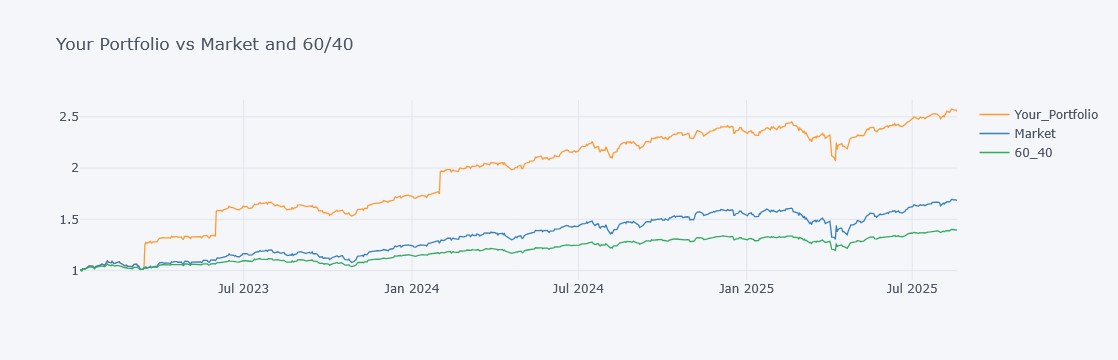


As of 2025-08-19:
  Cost basis: 31,537.45
  Market value: 48,640.41
  Unrealized P&L: 17,102.96
  Market TR since start: 68.05%
  60/40 TR since start: 39.48%


In [42]:
from pandas import Timestamp

# --- Start/end
ledger = ledger.copy()
ledger["buy_date"] = pd.to_datetime(ledger["buy_date"])
start = ledger["buy_date"].min()
end   = None

# --- Resolve holdings + benchmarks
requested = list(sorted(set(ledger["ric"]))) + [BENCH_RIC, BOND_PROXY]
res_map = resolve_list(requested)

print("Resolution map:")
for k, v in res_map.items():
    print(f"  {k:>10s} -> {v}")

# keep only resolved symbols
ledger["ric_resolved"] = ledger["ric"].map(res_map)
if ledger["ric_resolved"].isna().any():
    dropped_unresolved = ledger.loc[ledger["ric_resolved"].isna(), "ric"].tolist()
    print("[warn] Dropping unresolved positions:", dropped_unresolved)
    ledger = ledger.loc[ledger["ric_resolved"].notna()].copy()

# --- Pull prices for resolved IDs
kept_ids = sorted({v for v in res_map.values() if v is not None})
px = get_many_px(kept_ids, start=start, end=end)   # prints [skip] for any empty series
print("Fetched columns:", list(px.columns))

# --- Drop holdings that didn’t fetch (resolved but not present in px)
available = set(px.columns)
mask_avail = ledger["ric_resolved"].isin(available)
if (~mask_avail).any():
    dropped_missing = ledger.loc[~mask_avail, "ric"].tolist()
    print("[warn] Dropping positions not in downloaded panel:", dropped_missing)
    ledger = ledger.loc[mask_avail].copy()

if ledger.empty:
    raise RuntimeError("No holdings left after resolution/fetch. Check RICs/entitlements.")

# --- Align buy dates & buy prices (nearest trading day per series)
effective_dates, buy_prices = [], []
for r, d in zip(ledger["ric_resolved"], ledger["buy_date"]):
    s = px[r].dropna()
    pos = s.index.get_indexer([Timestamp(d)], method="nearest")[0]
    eff_dt = s.index[pos]
    effective_dates.append(eff_dt)
    buy_prices.append(float(s.iloc[pos]))

ledger["effective_buy_date"] = effective_dates
ledger["buy_price"] = buy_prices

# --- Daily position values & total portfolio value
dates = px.index
port_val = pd.Series(0.0, index=dates, name="Portfolio")
for _, row in ledger.iterrows():
    r, q, d0 = row["ric_resolved"], row["qty"], row["effective_buy_date"]
    s = px.loc[px.index >= d0, r] * q
    port_val.loc[s.index] = port_val.loc[s.index] + s

# --- Holdings breakdown (as of last date)
as_of = px.index[-1]
curr_px = px.loc[as_of]
holdings = ledger.copy()
holdings["curr_price"] = holdings["ric_resolved"].map(curr_px.to_dict())
holdings["market_value"] = holdings["curr_price"] * holdings["qty"]
holdings["pnl_abs"] = holdings["market_value"] - holdings["buy_price"]*holdings["qty"]
tot_mv = float(holdings["market_value"].sum())
holdings["weight"] = holdings["market_value"] / tot_mv

display(holdings[[
    "ric","ric_resolved","qty","buy_date","effective_buy_date","buy_price",
    "curr_price","market_value","pnl_abs","weight"
]].sort_values("market_value", ascending=False))

# --- Cost basis & returns
cost_basis = float((holdings["buy_price"] * holdings["qty"]).sum())
port_ret   = port_val.pct_change().fillna(0.0)

# --- Benchmarks (no re-probing; use what we already fetched)
bench_ret = pd.DataFrame(index=px.index)

mrk = res_map.get(BENCH_RIC)
if mrk in px.columns:
    bench_ret["Market"] = px[mrk].pct_change().fillna(0.0)
else:
    print("[note] Market benchmark not available; skipping Market.")

# pick first bond proxy that is ALREADY in px
bond_cols_in_px = [c for c in ("IEI.P","IEI","VGIT.P","VGIT","SCHR","IEF.P","IEF","AGG","BND","TLT","US10YT=RR") if c in px.columns]
BOND_USED = bond_cols_in_px[0] if bond_cols_in_px else None
if mrk in px.columns and BOND_USED:
    r_simple = px[[mrk, BOND_USED]].pct_change().fillna(0.0)
    bench_ret["60_40"] = 0.60 * r_simple[mrk] + 0.40 * r_simple[BOND_USED]
else:
    print(f"[note] Bond proxy for 60/40: {BOND_USED}")

# --- Perf table & curves
def perf_table(r: pd.DataFrame) -> pd.DataFrame:
    ANN=252
    r = r.dropna()
    curve = (1+r).cumprod()
    yrs = len(r)/ANN
    cagr = curve.iloc[-1]**(1/yrs) - 1
    vol  = r.std()*np.sqrt(ANN)
    sharpe = (r.mean()/r.std())*np.sqrt(ANN)
    mdd = (curve/curve.cummax()-1).min()
    return pd.DataFrame({"CAGR":cagr,"Ann.Vol":vol,"Sharpe":sharpe,"MaxDD":mdd}).sort_values("Sharpe", ascending=False)

comp = pd.concat([
    port_ret.rename("Your_Portfolio"),
    bench_ret.get("Market", pd.Series(dtype=float)).rename("Market"),
    bench_ret.get("60_40", pd.Series(dtype=float)).rename("60_40")
], axis=1).dropna(how="all")

fmt = {"CAGR":"{:.2%}","Ann.Vol":"{:.2%}","Sharpe":"{:.2f}","MaxDD":"{:.2%}"}
display(perf_table(comp).style.format(fmt))

curves = (1 + comp.fillna(0)).cumprod()
plot_df = curves.copy()
plot_df.index = plot_df.index.strftime("%Y-%m-%d")
plot_df.iplot(title="Your Portfolio vs Market and 60/40")

print(f"\nAs of {as_of.date()}:")
print(f"  Cost basis: {cost_basis:,.2f}")
print(f"  Market value: {tot_mv:,.2f}")
print(f"  Unrealized P&L: {tot_mv-cost_basis:,.2f}")
if "Market" in bench_ret:
    print(f"  Market TR since start: {(1+bench_ret['Market']).cumprod().iloc[-1]-1:.2%}")
if "60_40" in bench_ret:
    print(f"  60/40 TR since start: {(1+bench_ret['60_40']).cumprod().iloc[-1]-1:.2%}")
